In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.aug_pipelines import medium_aug
from stack_segmentation.io import make_dataloader, collate_fn_basic
from stack_segmentation.training import handle_stacks_data, make_model, train_loop
from stack_segmentation.unet import UNet
from stack_segmentation.pipeline_config import dataloaders_conf, model_conf, train_conf, loss_config

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
train_conf['device'] = 'cuda:1'
model_conf['device'] = 'cuda:1'

In [8]:
data_conf['conf_name'] = 'basic_lr1e-2_epoch300_soft_aug_k_2'
data_conf

{'conf_name': 'basic_lr1e-2_epoch300_soft_aug_k_2',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_test': (slice(None, None, None),
    slice(None, Non

In [9]:
from stack_segmentation.aug_pipelines import soft_aug
dataloaders_conf['train']['augmentation_pipeline'] = soft_aug(original_height=128, original_width=128, k=2)
dataloaders_conf

{'train': {'batch_size': 32,
  'num_workers': 8,
  'shuffle': True,
  'augmentation_pipeline': Compose([
    OneOf([
      RandomSizedCrop(always_apply=False, p=0.5, min_max_height=(64, 128), height=128, width=128, w2h_ratio=1.0, interpolation=1),
      PadIfNeeded(always_apply=False, p=0.5, min_height=128, min_width=128, border_mode=4, value=None, mask_value=None),
    ], p=1),
    VerticalFlip(always_apply=False, p=0.5),
    HorizontalFlip(always_apply=False, p=0.5),
    RandomRotate90(always_apply=False, p=0.5),
    Transpose(always_apply=False, p=0.5),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})},
 'val': {'batch_size': 32,
  'num_workers': 8,
  'shuffle': False,
  'augmentation_pipeline': None},
 'test': {'batch_size': 32,
  'num_workers': 8,
  'shuffle': True,
  'augmentation_pipeline': None}}

In [10]:
train_conf['num_epochs'] = 300
train_conf

{'num_epochs': 300, 'device': 'cuda:1'}

In [11]:
model_conf['opt_type'] = 'SGD'
model_conf['lr'] = 1e-2
model_conf['weight'] = None
model_conf['nesterov'] = True
model_conf

{'device': 'cuda:1',
 'opt_type': 'SGD',
 'lr': 0.01,
 'weight_decay': 0.0001,
 'amsgrad': False,
 'nesterov': True,
 'momentum': 0.9,
 'centered': False,
 'min_lr': 1e-06,
 'factor': 0.5,
 'patience': 5,
 'weight': None}

In [12]:
loss_config =[
    {'loss': 'BCE', 'weight': 1, 'params': {}},
]
loss_config

[{'loss': 'BCE', 'weight': 1, 'params': {}}]

In [13]:
data_conf['patches']

{'train': (128, 128, 1), 'val': (128, 128, 1), 'test': (128, 128, 1)}

## Prepare train, validation and test data

In [14]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:03, 214.20it/s]
100%|██████████| 720/720 [00:07<00:00, 95.13it/s] 
8280it [00:00, 100638.79it/s]
7920it [00:00, 245213.94it/s]
700it [00:03, 225.41it/s]
100%|██████████| 700/700 [00:06<00:00, 101.55it/s]
8280it [00:00, 241469.29it/s]
7920it [00:00, 236655.70it/s]
710it [00:03, 217.33it/s]
100%|██████████| 710/710 [00:07<00:00, 97.89it/s] 
7920it [00:00, 249582.17it/s]
7560it [00:00, 82209.27it/s]
720it [00:00, 808.97it/s]
100%|██████████| 720/720 [00:07<00:00, 95.07it/s] 
8280it [00:00, 239555.48it/s]
720it [00:03, 227.13it/s]
100%|██████████| 720/720 [00:07<00:00, 93.26it/s] 
25920it [00:00, 138475.07it/s]
700it [00:03, 228.48it/s]
100%|██████████| 700/700 [00:06<00:00, 102.16it/s]
25200it [00:00, 231027.99it/s]
509it [00:01, 379.43it/s]
100%|██████████| 509/509 [00:02<00:00, 194.70it/s]
8144it [00:00, 63573.48it/s]
700it [00:03, 228.54it/s]
100%|██████████| 700/700 [00:07<00:00, 98.70it/s] 
25200it [00:00, 224761.75it/s]
700it [00:00, 838.79it/s]
100%|██████████| 700/700 [0

In [15]:
len(data_train), len(data_val), len(data_test)

(24480, 23400, 11)

In [16]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [17]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [18]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [19]:
device = 'cuda:1'

In [20]:
model, criterion, optimizer, scheduler = make_model(loss_config=loss_config, **model_conf)

## Run experiment

In [21]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.0598


100%|██████████| 732/732 [00:52<00:00, 13.94it/s]


Mean val loss: 0.02915


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 1...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.033043


100%|██████████| 732/732 [00:53<00:00, 13.75it/s]


Mean val loss: 0.022011


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 2...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.031409


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.020671
Epoch 3...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.031083


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.019985
Epoch 4...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.03074


100%|██████████| 732/732 [00:52<00:00, 13.88it/s]


Mean val loss: 0.01995


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 5...


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.019554
Epoch 6...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.030145


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.0198
EarlyStopping counter: 1 out of 10
Epoch 7...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.029916


100%|██████████| 732/732 [00:52<00:00, 13.84it/s]


Mean val loss: 0.019084
Epoch 8...


 75%|███████▍  | 572/765 [01:55<00:39,  4.95it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.029241


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.017937
Epoch 16...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.029405


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.018477
EarlyStopping counter: 1 out of 10
Epoch 17...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.029217


 38%|███▊      | 275/732 [00:20<00:32, 14.06it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028626


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01728
EarlyStopping counter: 1 out of 10
Epoch 25...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028705


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.017551
EarlyStopping counter: 2 out of 10
Epoch 26...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028489


 98%|█████████▊| 721/732 [00:51<00:00, 13.99it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028103


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.017297
EarlyStopping counter: 1 out of 10
Epoch 34...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028116


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.017431
EarlyStopping counter: 2 out of 10
Epoch 35...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028008


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016821
EarlyStopping counter: 3 out of 10
Epoch 36...


 22%|██▏       | 166/765 [00:33<02:00,  4.97it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027797


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.017188
EarlyStopping counter: 4 out of 10
Epoch 44...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027666


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016725
EarlyStopping counter: 5 out of 10
Epoch 45...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027634


 33%|███▎      | 245/732 [00:18<00:34, 13.95it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027441


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01561
Epoch 53...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027662


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016357
EarlyStopping counter: 1 out of 10
Epoch 54...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027624


 51%|█████     | 373/732 [00:27<00:25, 14.06it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016247
EarlyStopping counter: 9 out of 10
Epoch 62...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027111


  0%|          | 0/259 [00:00<?, ?it/s]

Mean val loss: 0.01619
EarlyStopping counter: 10 out of 10


 77%|███████▋  | 607/788 [06:49<02:01,  1.49it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Dump experiment results

In [37]:
import pickle
import json

In [35]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [24]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [36]:
from itertools import chain

In [26]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [27]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

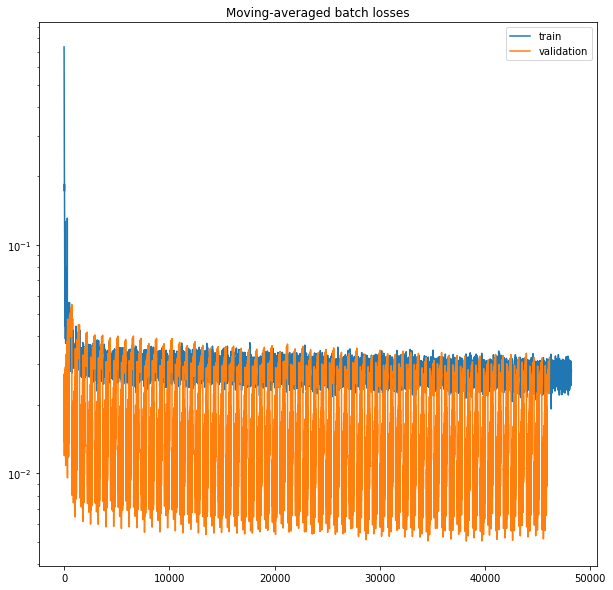

In [28]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [29]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

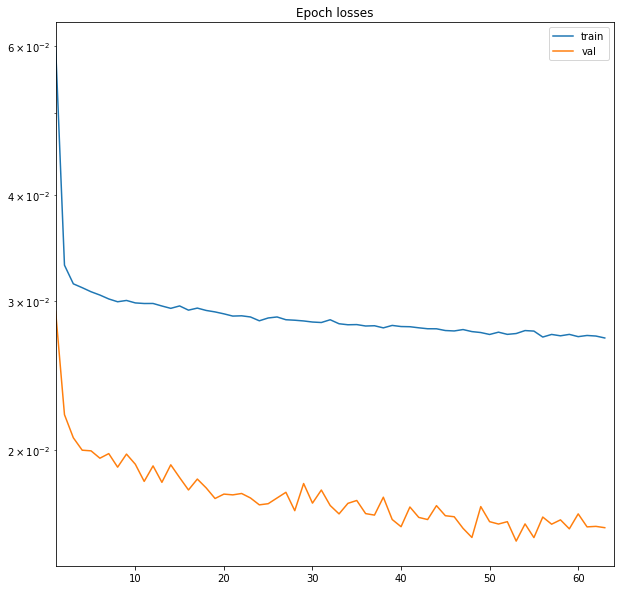

In [30]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [31]:
import pandas as pd

In [32]:
from visualization_utils import make_df

In [33]:
df = make_df(results, model_name='basic')
df

,accuracy,precision,recall,f1,pr_auc,iou,stack,model
0,0.996010,0.965395,0.984354,0.974783,0.998108,0.950806,carb96558,basic
1,0.988377,0.927443,0.983134,0.954477,0.994126,0.912918,carb71,basic
2,0.971275,0.996194,0.767893,0.867271,0.988616,0.765647,carbRNF,basic
3,0.990021,0.997339,0.913862,0.953778,0.997149,0.911640,SPE_carb10_58_box3,basic
4,0.992481,0.988382,0.931597,0.959149,0.995531,0.921505,SoilAh-1,basic
5,0.996407,0.967269,0.970103,0.968684,0.996783,0.939269,SoilB-2,basic
6,0.989126,0.995724,0.912821,0.952472,0.996852,0.909257,TeTree_subset1,basic
7,0.993645,0.996221,0.938616,0.966561,0.998377,0.935286,TiTree_subset2,basic
8,0.991938,0.968156,0.967249,0.967702,0.996659,0.937426,Urna_22,basic
9,0.990125,0.972806,0.966950,0.969869,0.997315,0.941501,Urna_30,basic


In [34]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.91184
Std    IOU: 0.050868
Min    IOU: 0.76565
Median IOU: 0.92151
